<a href="https://colab.research.google.com/github/MaxYeeet/VLAD_numbers/blob/CNN-from-CoLab/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [ ]:
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("Используемая версия TF:", tf.__version__)
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
print("Используемая версия Keras:", keras.__version__)

Используемая версия TF: 2.12.0
Используемая версия Keras: 2.12.0


In [ ]:
# проверяем что у нас работает GPU
tf.test.gpu_device_name()
# выводим данные об используемой GPU
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-c63b8a3c-69a2-87e3-8439-7f3a5b5c5cdf)
Thu Jun 15 05:53:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    29W /  70W |    387MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

# Загружаем данные

In [ ]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [ ]:
# чекаем данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


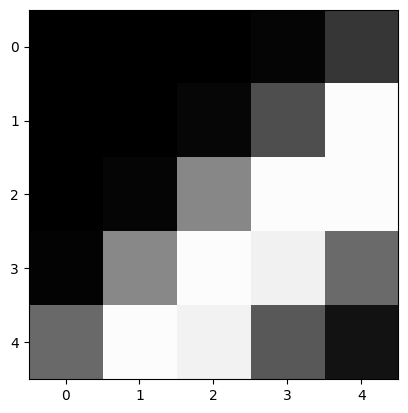

Пример картинки:


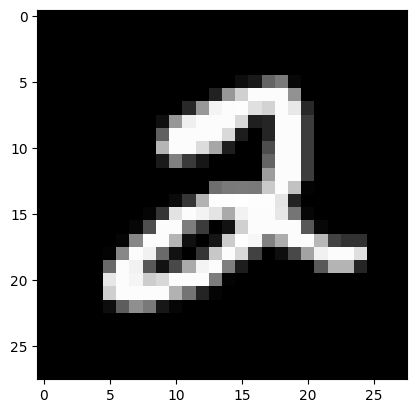

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [ ]:
# нарисуем картинку по рофлу
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

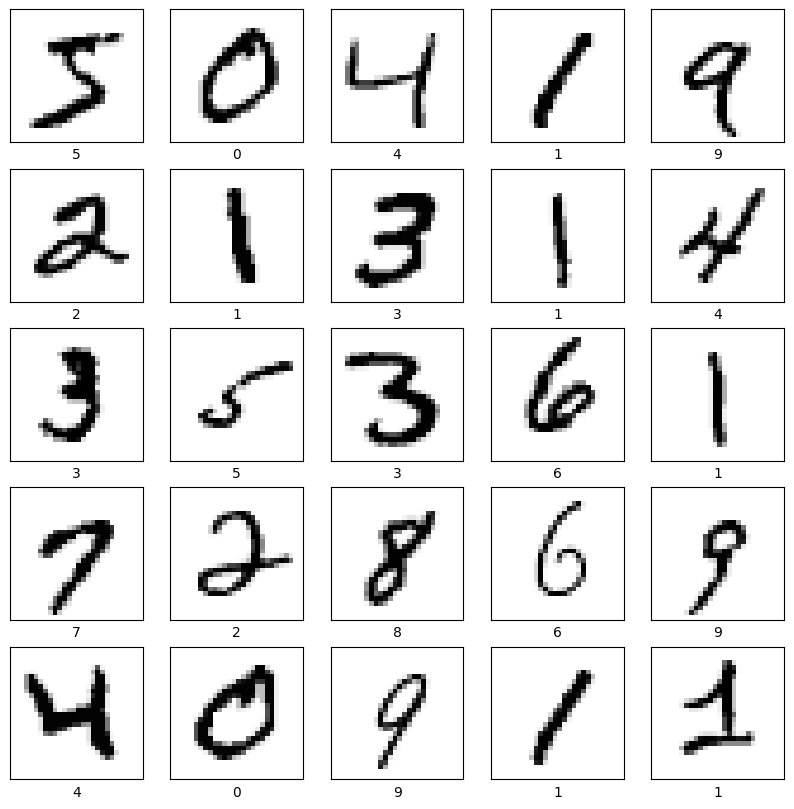

In [ ]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Обрабатываем данные

In [ ]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


In [ ]:
# центрируем и нормируем
x_train_float = x_train.astype(np.float) / 255
x_val_float = x_val.astype(np.float) / 255

<ipython-input-8-c6dffbdc558c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_float = x_train.astype(np.float) / 255
<ipython-input-8-c6dffbdc558c>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val_float = x_val.astype(np.float) / 255


# Задаём архитектуру сети

Нам понадобятся такие слои:

  Conv2D - сверточный слой:

*   filters: количество фильтров на выходе;
*   kernel_size: размер скользящего окна;
*   padding: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
*   input_shape: размер входа вида (W, H, C_in).

MaxPooling2D - пулинг

Flatten - все оси, кроме батча (первой) вытягиваются в один вектор.

Dense - плотный, активацию можно задать через activation="elu" или activation="softmax".

Dropout - дропаут регуляризация (уменьшение картинки без фильтров для оптимизации)

In [ ]:
K.clear_session()

model = M.Sequential();
model.add(L.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', input_shape = (28,28,1)));
model.add(L.BatchNormalization());
model.add(L.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same'));
model.add(L.BatchNormalization());
model.add(L.MaxPool2D(pool_size = 2));
model.add(L.Dropout(0.25))
model.add(L.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same'));
model.add(L.BatchNormalization());
model.add(L.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same'));
model.add(L.BatchNormalization());
model.add(L.MaxPool2D(pool_size = 2));
model.add(L.Dropout(0.25))
model.add(L.Flatten());
model.add(L.Dense(256, activation = 'relu'));
model.add(L.BatchNormalization());
model.add(L.Dropout(0.5))
model.add(L.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

# Тренируем сеть

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # выбираем оптимайзер
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
K.clear_session()

In [ ]:
history = model.fit(
    x_train_float[:, :, :, np.newaxis],
    y_train_oh,
    batch_size=32,
    epochs=20,
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)
)

Epoch 1/20
1875/1875 [==============================] - 19s 7ms/step - loss: 0.1955 - accuracy: 0.9397 - val_loss: 0.0453 - val_accuracy: 0.9860
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0995 - accuracy: 0.9688 - val_loss: 0.0480 - val_accuracy: 0.9854
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0822 - accuracy: 0.9750 - val_loss: 0.0359 - val_accuracy: 0.9870
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0748 - accuracy: 0.9769 - val_loss: 0.0385 - val_accuracy: 0.9879
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0646 - accuracy: 0.9797 - val_loss: 0.0357 - val_accuracy: 0.9870
Epoch 6/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0607 - accuracy: 0.9812 - val_loss: 0.0246 - val_accuracy: 0.9921
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0543 - accuracy: 0.9832 - val_loss: 0.0239 - val_ac

График точности:

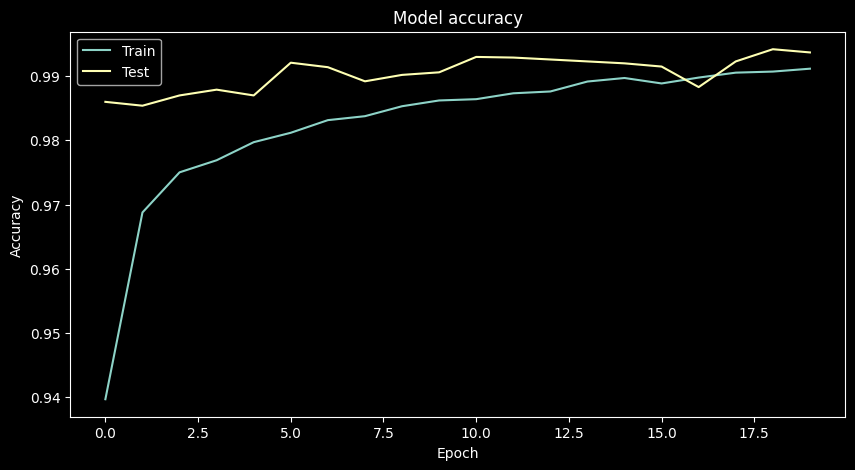

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

График потерь:

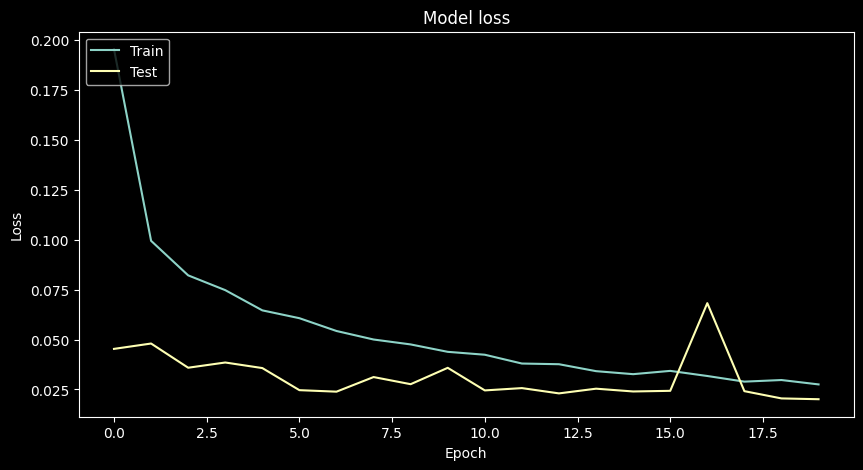

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save("mnist_1_full.h5")

In [ ]:
model.predict_classes(x_val_float)
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

AttributeError: ignored